In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import torch

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")


CUDA available: True
Number of CUDA devices: 1
Current CUDA device: Tesla T4


In [8]:
!pip install timm

  Using cached timm-0.9.16-py3-none-any.whl (2.2 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  U

# 新段落

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

import timm

import os
import time
import random
from datetime import datetime

from PIL import Image
from sklearn import model_selection


In [10]:
def seed_everything(seed):

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [11]:
# general global variables
DATA_PATH = "/content/drive/MyDrive/Colab_Notebooks/AMLSII_23-24_SN23202365/Datasets"
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/AMLSII_23-24_SN23202365/Datasets/train"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/AMLSII_23-24_SN23202365/Datasets/test"


# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 0.001
N_EPOCHS = 200

In [12]:
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


<Axes: xlabel='diagnosis'>

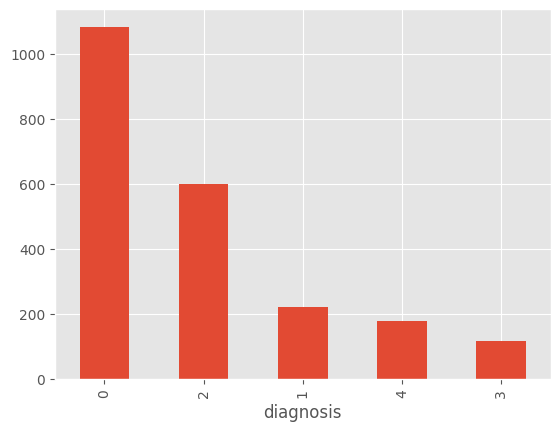

In [13]:
df.diagnosis.value_counts().plot(kind="bar")

In [14]:
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.diagnosis.values
)

In [15]:
class RetinaDataset(torch.utils.data.Dataset):

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train" if mode == "train" else "test"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):

          row = self.df_data[index]

          if self.mode == "train":

              img_name, label = row[0], row[1]
              img_name = f"{img_name}.png"

          else:

              img_name = row[0]

          img_path = os.path.join(self.data_path, self.data_dir, img_name)
          img = Image.open(img_path).convert("RGB")

          if self.transforms is not None:
              image = self.transforms(img)

          return (image, label) if self.mode == "train" else image

In [16]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [17]:
print("Available Vision Transformer Models: ")
timm.list_models("convnext_base")
# timm.list_models("regnet*")

Available Vision Transformer Models: 


['convnext_base']

In [18]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("convnext_base", pretrained=False)

        # self.model.head = nn.Linear(self.model.head.in_features, n_classes)
        # self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
        self.model.head.fc = nn.Linear(self.model.head.fc.in_features, n_classes)



    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):

        epoch_loss = 0.0
        epoch_accuracy = 0.0

        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            optimizer.zero_grad()

            output = self.forward(data)
            loss = criterion(output, target)

            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

            optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):

        valid_loss = 0.0
        valid_accuracy = 0.0

        self.model.eval()
        for data, target in valid_loader:

            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():

                output = self.model(data)
                loss = criterion(output, target)

                accuracy = (output.argmax(dim=1) == target).float().mean()
                valid_loss += loss.item()
                valid_accuracy += accuracy.item()

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [19]:
def fit_gpu(model, epochs, device, criterion, optimizer, train_loader, valid_loader=None, scheduler=None, early_stopping_patience=10):
    valid_loss_min = np.Inf
    stop_early = False
    epochs_no_improve = 0

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        if stop_early:
            print("Early stopping triggered!")
            break

        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            train_loader, criterion, optimizer, device
        )
        print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        if valid_loader is not None:
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                valid_loader, criterion, device
            )
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            # check if validation loss has decreased
            if valid_loss < valid_loss_min:
                last_model_save_epoch = epoch
                epochs_no_improve = 0  
                valid_loss_min = valid_loss  
                print(
                    "Validation loss decreased. Saving model ..."
                )
                torch.save(model, 'best_model.pth')
            else:
                epochs_no_improve += 1  # increment counter
                print(f"No improvement in validation loss for {epochs_no_improve} consecutive epochs.")

            # check for early stopping
            if epochs_no_improve >= early_stopping_patience:
                print(f"Validation loss did not decrease for {early_stopping_patience} consecutive epochs. Early stopping...")
                stop_early = True
        if scheduler is not None:
          scheduler.step(valid_loss)

    return {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_accs": train_accs,
        "valid_accs": valid_accs,
        "last_model_save_epoch": last_model_save_epoch,  
    }


In [20]:
model = ViTBase16(n_classes=5, pretrained=True)

In [21]:
def run():
    train_dataset = RetinaDataset(train_df, transforms=transforms_train)
    valid_dataset = RetinaDataset(valid_df, transforms=transforms_valid)


    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=True,
    )

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    lr = LR
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                                           threshold=0.01, threshold_mode='rel', cooldown=0,
                                           min_lr=0, eps=1e-08, verbose=True)

    if device.type == "cuda":
      print(f"INITIALIZING TRAINING ON GPU")
    else:
      print(f"INITIALIZING TRAINING ON CPU")
    start_time = datetime.now()
    print(f"Start Time: {start_time}")

    logs = fit_gpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
        scheduler=scheduler
    )

    print(f"Execution time: {datetime.now() - start_time}")
    print("Saving Model")

    torch.save(model, '/content/drive/MyDrive/Colab_Notebooks/AMLSII_23-24_SN23202365/best_model_convnext.pth')
    return logs




In [22]:
logs = run()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


INITIALIZING TRAINING ON GPU
Start Time: 2024-04-10 14:48:16.189871
EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 1.7217770795353124, ACCURACY: 0.45235655737704916

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 1.3308022618293762, ACCURACY: 0.484375

Validation loss decreased. Saving model ...
EPOCH 2 - TRAINING...

	[TRAIN] EPOCH 2 - LOSS: 1.3461347036674374, ACCURACY: 0.4697745901639344

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 1.3269566496213276, ACCURACY: 0.484375

Validation loss decreased. Saving model ...
EPOCH 3 - TRAINING...

	[TRAIN] EPOCH 3 - LOSS: 1.348431700565776, ACCURACY: 0.47899590163934425

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 1.2987583875656128, ACCURACY: 0.484375

Validation loss decreased. Saving model ...
EPOCH 4 - TRAINING...

	[TRAIN] EPOCH 4 - LOSS: 1.3310015533791213, ACCURACY: 0.4667008196721312

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 1.3394549290339153, ACCURACY: 0.484375

No improvement in validation loss for 1 consecutive epochs.
EPOCH 5 - TRAINING...

	[TRAIN]

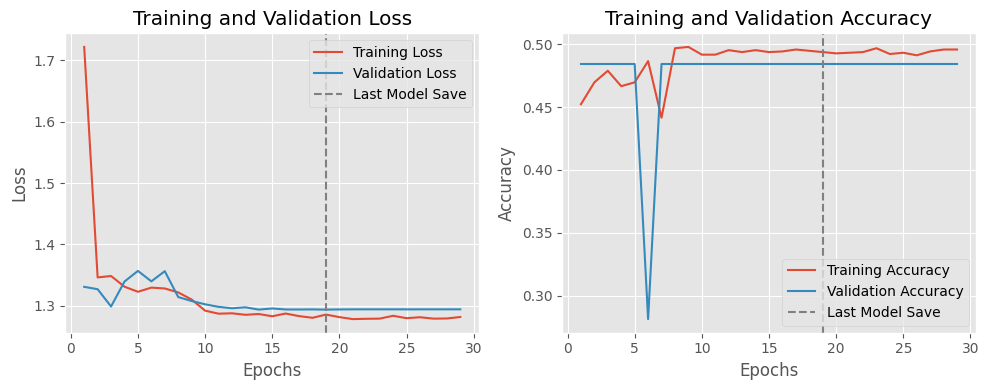

In [23]:

train_losses = logs['train_losses']
valid_losses = logs['valid_losses']
train_accs = logs['train_accs']
valid_accs = logs['valid_accs']
last_model_save_epoch = logs['last_model_save_epoch']

epochs_range = range(1, len(train_losses) + 1)

# Plot for loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, valid_losses, label='Validation Loss')
plt.axvline(x=last_model_save_epoch, color='grey', linestyle='--', label='Last Model Save')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, valid_accs, label='Validation Accuracy')
plt.axvline(x=last_model_save_epoch, color='grey', linestyle='--', label='Last Model Save')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/AMLSII_23-24_SN23202365/convnext.png')
plt.show()



In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab_Notebooks/AMLSII_23-24_SN23202365/best_model_convnext.pth'
CSV_OUTPUT_PATH= '/content/drive/MyDrive/Colab_Notebooks/AMLSII_23-24_SN23202365/classification_results.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for inference.")

model = torch.load(MODEL_PATH).to(device)
model.eval()

test_image_files = os.listdir(TEST_PATH)

test_df = pd.DataFrame({
    'id_code': test_image_files
})


test_dataset = RetinaDataset(test_df, mode='test', transforms=transforms_test)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

results = []

for i, data in enumerate(test_loader):
    data = data.cuda()
    outputs = model(data)
    _, predictions = torch.max(outputs, 1)
    results.extend(predictions.cpu().numpy())

# filenames = [x[0].split('/')[-1].split('.')[0] for x in TEST_PATH]

test_image_files = [os.path.splitext(filename)[0] for filename in test_image_files]
test_df = pd.DataFrame({
    'id_code': test_image_files,
    'diagnosis': results
})

test_df.to_csv(CSV_OUTPUT_PATH, index=False)